In [1]:
import imageio
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.fftpack import dct
from numpy.linalg import inv,det
from scipy.stats import multivariate_normal

In [2]:
train_samples = loadmat('./data/TrainingSamplesDCT_8_new.mat')
train_samples_fg = train_samples['TrainsampleDCT_FG']
train_samples_bg = train_samples['TrainsampleDCT_BG']
zig_zag = np.genfromtxt('./data/zig_zag_pattern.txt', dtype=np.int64).flatten()
image = np.array(imageio.imread('./data/cheetah.bmp'), dtype=np.float64)/255
image2 = loadmat('./data/cheetah.mat')['img']
ground_truth = np.array(imageio.imread('./data/cheetah_mask.bmp'), dtype=np.float64)/255

In [3]:
def zz_scan(block):
    scanned = np.zeros(64)
    for i in range(64):
        scanned[zig_zag[i]] = block[i]
    return scanned

In [4]:
def dct2d(block):
    return dct(dct(block.T, norm='ortho').T, norm='ortho').flatten()

In [5]:
def process_image():
    transformed_blocks = []
    for i in range(image2.shape[0]-8):
        for j in range(image2.shape[1]-8):
            block = image2[i:i+8,j:j+8]
            transformed_block = dct2d(block).flatten()
            transformed_block = zz_scan(transformed_block)
            transformed_blocks.append(transformed_block)
    return np.array(transformed_blocks)

In [42]:
def random_init(C, M, D, W=0.25):
    pi = np.ones(C)/C
    mu = np.random.randn(C, D)
    sigma = []
    for c in range(C):
        sigma.append(np.diag(np.random.normal(M, W, size=D)))
    sigma = np.array(sigma)
    return pi, mu, sigma

In [37]:
def EM(C, M, D, sample, max_iter):
    pi,mu,cov = random_init(C, M, D)
    for i in range(max_iter):
        # E step
        H = []
        for c in range(C):
            H.append(multivariate_normal.pdf(sample, mean=mu[c,:], cov=cov[c,:,:]) * pi[c])
        H = np.array(H).T
        H /= np.sum(H,axis = 1)[:,np.newaxis]
        H_sum = np.sum(H,axis = 0)
        
        # M step
        new_mu = []
        new_cov = []
        for c in range(C):
            new_mu.append(np.sum(H[:, c][:, np.newaxis]*sample, axis=0)/H_sum[c])
            temp = np.sum(((sample - mu[c, :]) ** 2) * H[:, c][:, np.newaxis], axis=0) / H_sum[c]
            temp[temp < 1e-8] = 1e-8
            new_cov.append(np.diag(temp))
        pi = H_sum/sample.shape[0]
        mu = np.array(new_mu)
        cov = np.array(new_cov)
    return pi, mu, cov

In [32]:
def bdr(fg, fg_pi, fg_mu, fg_cov, bg, bg_pi, bg_mu, bg_cov, dim):
    l = image2.shape[0]-8
    w = image2.shape[1]-8
    d = fg_mu.shape[0]
    fg_mu= fg_mu[:,:dim]
    fg_cov= fg_cov[:,:dim,:dim]
    bg_mu= bg_mu[:,:dim]
    bg_cov= bg_cov[:,:dim,:dim]
    blocks = process_image()[:, :dim]
    p_cheetah = np.zeros(l*w)
    p_grass = np.zeros(l*w)
    A = np.zeros(l*w)
    for i in range(d):
        p_cheetah += multivariate_normal.pdf(blocks, mean=fg_mu[i], cov=fg_cov[i]) * fg_pi[i]
        p_grass += multivariate_normal.pdf(blocks, mean=bg_mu[i], cov=bg_cov[i]) * bg_pi[i]
    A = p_cheetah - p_grass
    A = np.where(A>0, 1, 0)
    A = np.reshape(A,(l,w))                
    A = np.lib.pad(A,(4,4),'constant',constant_values = 0)
    return A

In [34]:
def mvg(x, mu, cov):
    part1 = 1 / ( ((2* np.pi)**(len(mu)/2)) * (np.linalg.det(cov)**(1/2)) )
    part2 = (-1/2) * ((x-mu).T.dot(np.linalg.inv(cov))).dot((x-mu))
    return float(part1 * np.exp(part2))

In [22]:
C = 8
M = 5
D = train_samples_fg.shape[1]
iterations = 10
dimension = np.array((1,2,4,8,16,24,32,40,48,56,64))

In [41]:
error_list_a = []
for m_fg in range(M):
    fg_pi, fg_mu, fg_cov = EM(C, M, D, train_samples_fg, iterations)
    for m_bg in range(M):
        bg_pi, bg_mu, bg_cov = EM(C, M, D, train_samples_bg, iterations)
        error_list = []
        for dim in dimension:
            A = bdr(train_samples_fg, fg_pi, fg_mu, fg_cov, train_samples_bg, bg_pi, bg_mu, bg_cov, dim)
            error = A != ground_truth
            p_error = np.sum(error) / A.size
            error_list.append(p_error)
            print('FG{} BG{} dim{} P(error) = {}'.format(m_fg, m_bg, dim, p_error))
        error_list_a.append(error_list)

FG0 BG0 dim1 P(error) = 0.061830065359477125
FG0 BG0 dim2 P(error) = 0.06056644880174292
FG0 BG0 dim4 P(error) = 0.060856935366739286
FG0 BG0 dim8 P(error) = 0.06392156862745098
FG0 BG0 dim16 P(error) = 0.05003631082062455


KeyboardInterrupt: 

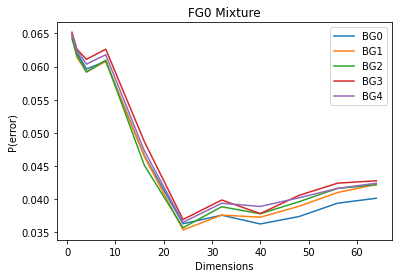

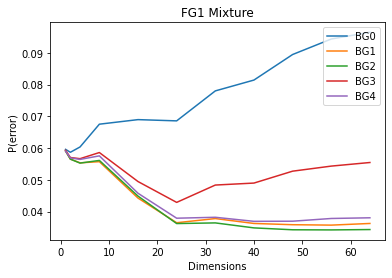

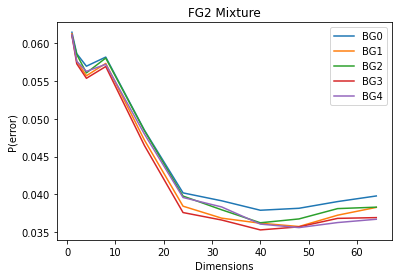

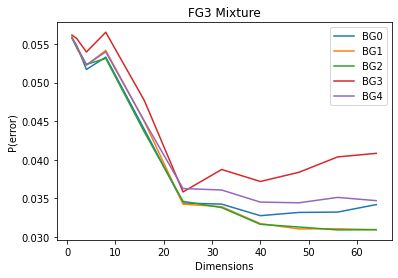

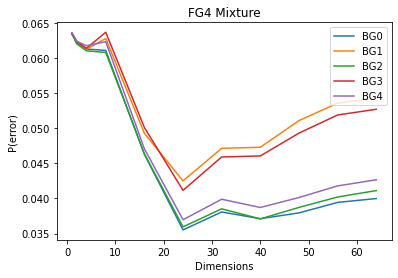

In [11]:
for i in range(M):
    for j in range(M):
        plt.plot(dimension, error_list_a[j+5*i], label='BG{}'.format(j))
    plt.legend(loc='upper right')
    plt.title('FG{} Mixture'.format(i))
    plt.xlabel('Dimensions')
    plt.ylabel('P(error)')
    plt.show()

In [12]:
C = np.array((1, 2, 4, 8, 16, 32))

In [15]:
error_list_b = []
for c in C:
    fg_pi, fg_mu, fg_cov = EM(c, M, D, train_samples_fg, iterations)
    bg_pi, bg_mu, bg_cov = EM(c, M, D, train_samples_bg, iterations)
    error_list = []
    for dim in dimension:
        A = bdr(train_samples_fg, fg_pi, fg_mu, fg_cov, train_samples_bg, bg_pi, bg_mu, bg_cov, dim)
        error = A != ground_truth
        p_error = np.sum(error) / A.size
        error_list.append(p_error)
    error_list_b.append(error_list)

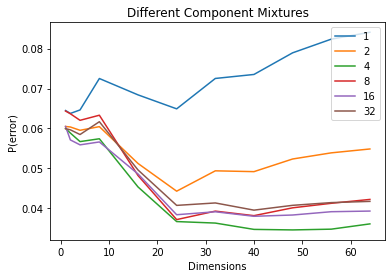

In [19]:
for i, c in enumerate(C):
    plt.plot(dimension, error_list_b[i],label = '{}'.format(c))
plt.legend(loc='upper right')
plt.title('Different Component Mixtures')
plt.xlabel('Dimensions')
plt.ylabel('P(error)')
plt.show()